In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy

C:\Users\varun\Anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [97]:
series = read_csv('g4_pi.csv', header=0, parse_dates=[0])
series = series.set_index("Date")
raw_values = series.pi_fatalities.values

---


In [98]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [99]:
# transform data to be stationary
diff_values = difference(raw_values, 1)

---

In [100]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [101]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

supervised_raw_values = timeseries_to_supervised(raw_values, 1) #for reference with orginal raw values
supervised_values_raw_values = supervised_raw_values.values #for reference with orginal raw values

---

In [102]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [103]:
# split data into train and test-sets, 70-30 split
train, test = supervised_values[0:-30], supervised_values[-30:]

In [104]:
# Reference Values
train_raw_values, test_raw_values = supervised_values_raw_values[0:-30], supervised_values_raw_values[-30:]

In [105]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

---
***
---

In [106]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    
    #Given that the training dataset is defined as X inputs and y outputs, 
    #it must be reshaped into the Samples/TimeSteps/Features format
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

---
___Fit the model___

In [117]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 80, 10)

In [118]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.01311491],
       [ 0.93224275],
       [-0.191304  ],
       [ 0.09493329],
       [-0.16088368],
       [ 0.06904984],
       [-0.03557535],
       [ 0.04892439],
       [ 0.06899651],
       [-0.03071754],
       [ 0.47557196],
       [-0.3000408 ],
       [ 0.15275905],
       [ 0.5769957 ],
       [-0.1623534 ],
       [ 0.3558884 ],
       [ 0.07851782],
       [-0.03560866],
       [-0.02612213],
       [ 0.1949815 ],
       [ 0.02521474],
       [ 0.2556955 ],
       [ 0.35727164],
       [ 0.13498689],
       [-0.2885501 ],
       [ 0.06529838],
       [ 0.48437944],
       [ 0.06134167],
       [ 0.0915461 ],
       [ 0.12212431],
       [-0.02523872],
       [ 0.09121118],
       [ 0.33255917],
       [ 0.09848981],
       [ 0.29279098],
       [ 0.15188877],
       [ 0.23878513],
       [-0.15361764],
       [-0.24584045],
       [ 0.3569439 ],
       [-0.05944733],
       [ 0.43792257],
       [ 0.40165767],
       [ 0.17880024],
       [ 0.00528114],
       [ 0

---

In [119]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [120]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

---

In [121]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

---

In [122]:
# walk-forward validation on the test data
predictions = list()

In [123]:
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
#     print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Test RMSE: 104.567


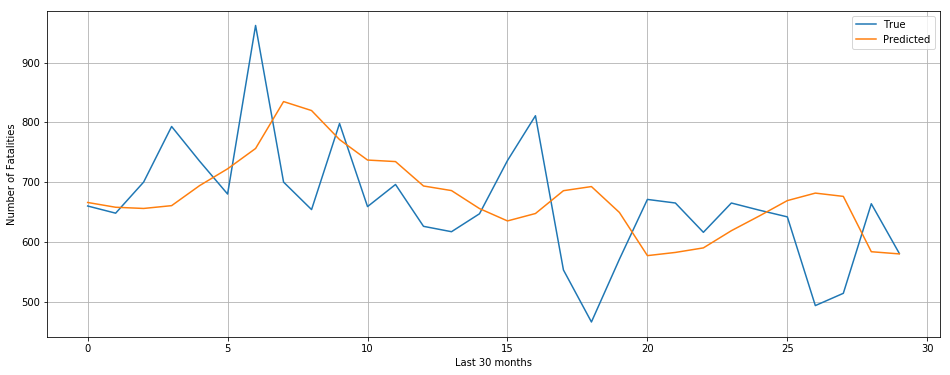

In [124]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-30:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize = (16, 6))
plt.plot(raw_values[-30:])
plt.plot(predictions)
plt.xlabel("Last 30 months")
plt.ylabel("Number of Fatalities")
plt.grid()
plt.legend(('True', 'Predicted'))
plt.show()

fixed_raw_values = raw_values[-30:]

---

In [125]:
for j in range (5):
    raw_values = numpy.append( raw_values , predictions[-1] )

    # transform data to be stationary
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    supervised_raw_values = timeseries_to_supervised(raw_values, 1) #for reference with orginal raw values
    supervised_values_raw_values = supervised_raw_values.values #for reference with orginal raw values

    # split data into train and test-sets, 70-30 split
    train, test = supervised_values[0:-30], supervised_values[-30:]

    # Reference Values
    train_raw_values, test_raw_values = supervised_values_raw_values[0:-30], supervised_values_raw_values[-30:]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)


    # make one-step forecast
    # make one-step forecast
    X, y = test_scaled[-1, 0:-1], test_scaled[-1, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat1 = inverse_difference(raw_values, yhat, -1)
    # store forecast
    predictions.append(yhat1)



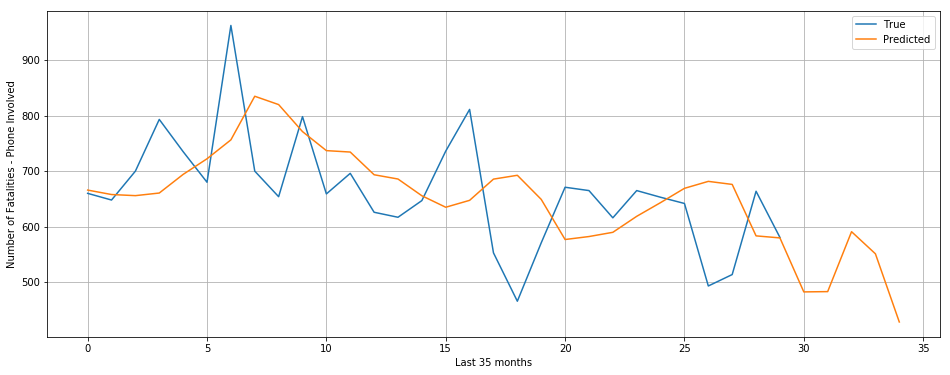

In [126]:
# line plot of observed vs predicted
fig = plt.figure(figsize = (16, 6))
plt.plot(fixed_raw_values)
plt.plot(predictions)
plt.xlabel("Last 35 months")
plt.ylabel("Number of Fatalities - Phone Involved")
plt.legend(('True', 'Predicted'))
plt.grid()
plt.show()
fig.savefig('g4_total_fatalities_pi', dpi = 300)

In [127]:
len(test_scaled)

30

In [128]:
lstm_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8_input (InputLayer)    (1, 1, 1)                 0         
_________________________________________________________________
lstm_8 (LSTM)                (1, 10)                   480       
_________________________________________________________________
dense_8 (Dense)              (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
